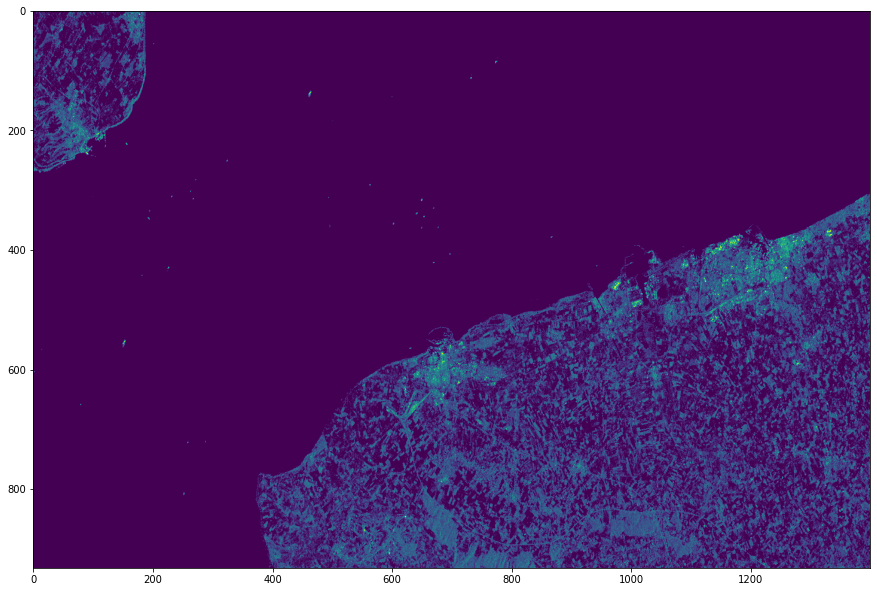

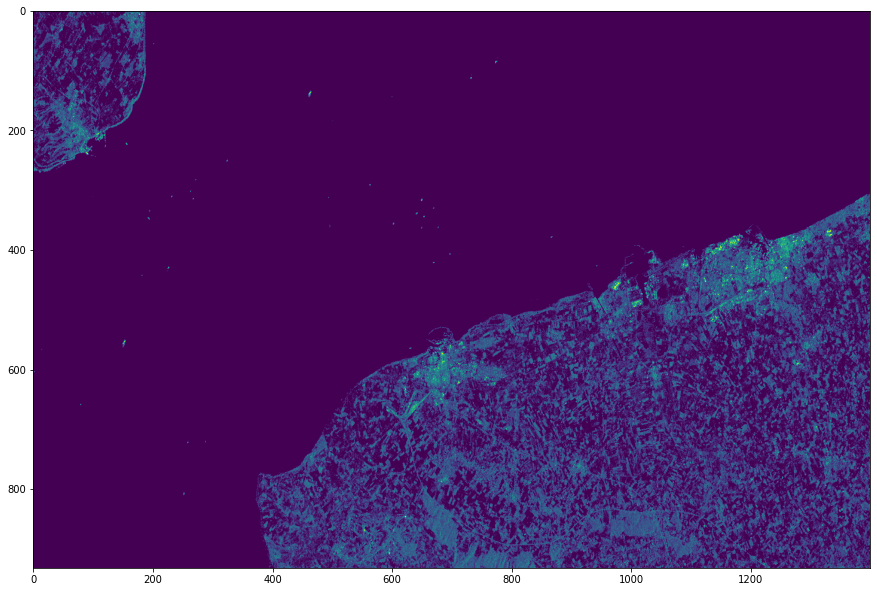

0 255 (932, 1400, 2)


In [18]:
from sentinelhub import CRS, BBox, MimeType, SentinelHubRequest, SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import cv2

plt.rcParams["figure.figsize"] = (15, 15)


delta_x = 1.3
delta_y = 0.42
center = (1.881302, 51.011409, )
bbox = (
    center[0] - delta_x / 2,
    center[1] - delta_y / 2,
    center[0] + delta_x / 2,
    center[1] + delta_y / 2,
)
bbox = BBox(bbox, crs=CRS.WGS84)
size = (1400, 932)
time_interval = "2020-07-15", "2020-09-16"
evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["VV", "VH"]
        }],
        output: {
            bands: 2
        }
    };
}


function evaluatePixel(samples) {

  const value = Math.max(0, Math.log(samples.VH) * 0.21714724095 + 1);



  return {

    default: [value, value, value, samples.dataMask],

    eobrowserStats: [(10 * Math.log(samples.VH)) / Math.LN10],

    dataMask: [samples.dataMask],

  };

}


"""

config = SHConfig()
CLIENT_ID = ""
CLIENT_SECRET = ""
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1,
            time_interval=time_interval
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
)


image = request.get_data()[0]
# Increase the plot size and font size.
plt.rcParams["figure.figsize"] = (15, 15)
plt.imshow(image[...,0])
plt.show()

plt.imshow(image[...,1])
plt.show()
print(np.min(image), np.max(image), image.shape)

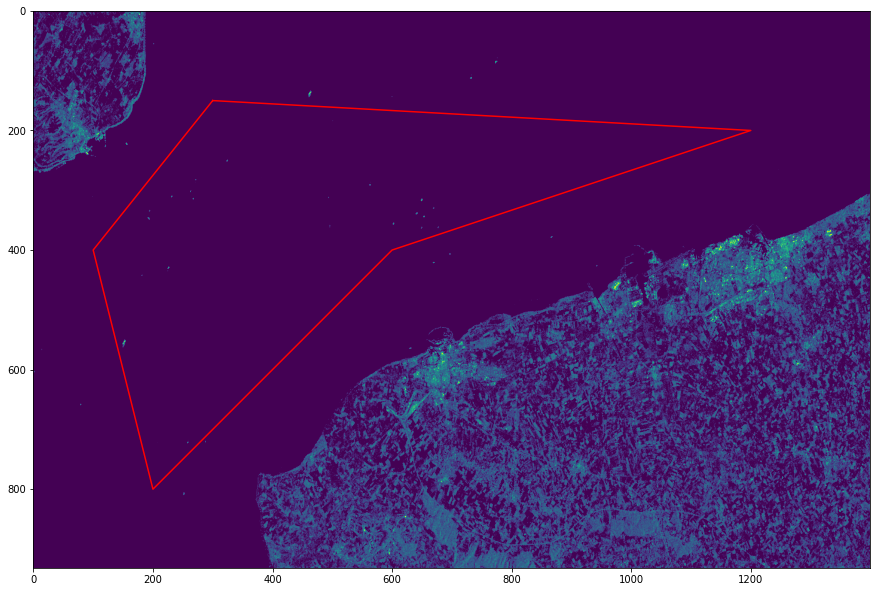

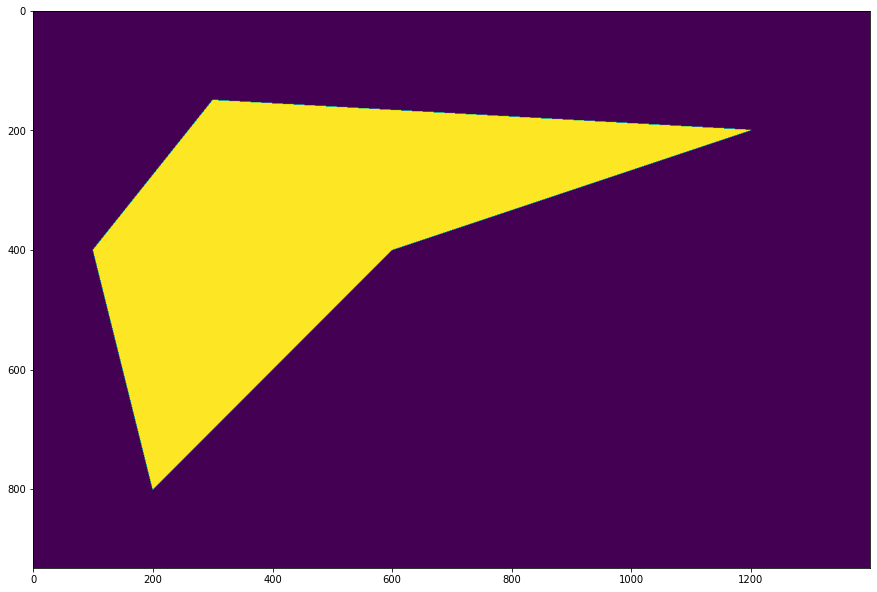

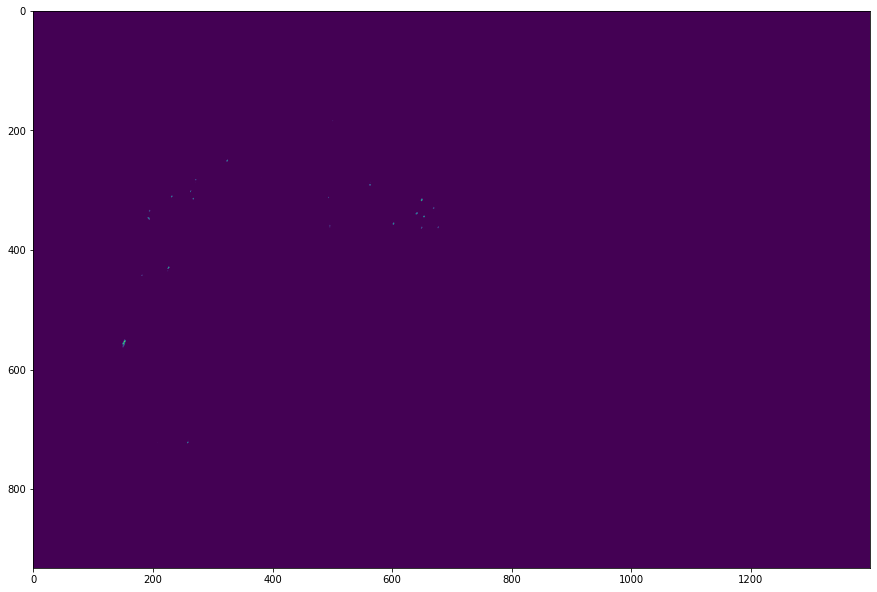

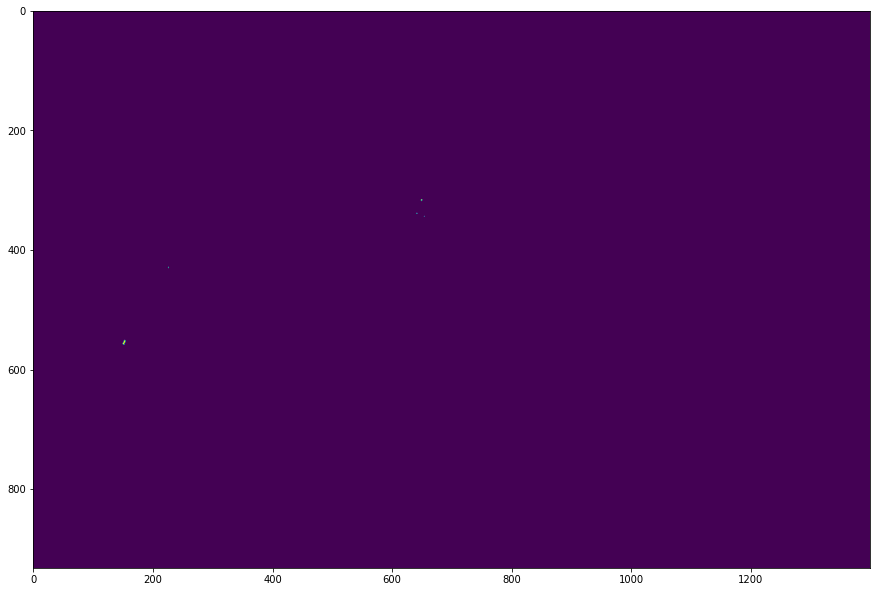

In [19]:
polygon = [
    [150, 300],
    [400, 100],
    [800, 200],
    [400, 600],
    [200, 1200]
]
polygon = [(y, x) for x, y in polygon]
# Plot the image and overlay the polygon.
plt.imshow(image[...,0])
closed_polygon = np.array(polygon + [polygon[0]])
plt.plot(*zip(*closed_polygon), color="red")
plt.show()
mask = np.zeros(image.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask, np.int32([polygon]), 1)
masked_image = image[..., 0] * mask
plt.imshow(mask)
plt.show()

plt.imshow(masked_image)
plt.show()


# Gaussian smoothing.
sigma = 1
smoothed_image = filters.gaussian_filter(masked_image.astype(float) / 255, sigma=sigma)
threshold = 0.3
thresholded_image = (smoothed_image > threshold).astype(np.uint8)
plt.imshow(thresholded_image)
plt.show()



Number of connected components: 5


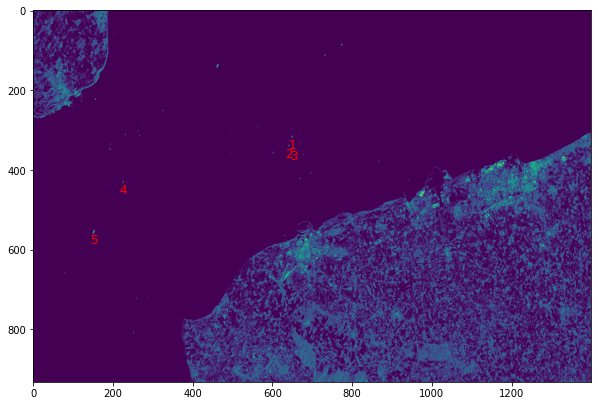

In [20]:
# Find connected components.
labeled_image, num_labels = ndimage.label(thresholded_image)

# Count the number of connected components.
print(f"Number of connected components: {num_labels}")

# Plot the labeled image with numbers next to each connected component.
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image[...,0])
for label in range(1, num_labels + 1):
    # Find the center of mass of the connected component.
    y, x = ndimage.measurements.center_of_mass(labeled_image == label)

    # Plot the number of the connected component next to it.
    ax.text(x, y+20, label, color="red", fontsize=12, ha="center", va="center")

plt.show()